# Baseline 2 — LSTM (many-to-one) con ventana deslizante
**Fecha:** 2025-08-20 12:57

**Objetivo:** Adaptación del notebook *03-DRNNs_series_temporales_con_embeddings* para un **segundo baseline** con **LSTM** y **pronóstico de 1 día** sobre `df_tienda1_preprocesado`.

## Índice (Outline)
1. **Configuración & Hiperparámetros**
2. **Carga / Entrada de datos**
3. **Selección de variables (Univariante / Multivariante)**
4. **Preprocesado**: escalado selectivo, verificación de binarios
5. **Enventanado (many-to-one)**
6. **Partición temporal**: train (80%) → (train/val), test (20%)
7. **Modelo LSTM** (tanh/ sigmoid por defecto)
8. **Entrenamiento** con EarlyStopping y Checkpoint
9. **Evaluación**: MAE (principal), sMAPE, R²
10. **Gráficas**: pérdidas (marcando el mejor punto), reales vs. predichas (desescaladas)
11. **Forecast 1 paso** sobre test
12. **Notas y siguientes pasos**


In [5]:
# =============================
# 1) CONFIGURACIÓN & HIPERPARÁMETROS
# =============================
# Todos los hiperparámetros en MAYÚSCULAS, como solicitado.

# Ventana temporal (lookback / time_steps)
TIME_STEPS = 30   # puede ser 7/14/30, etc.

# Arquitectura / Entrenamiento
LSTM_UNITS = 64          # sugerido: 32–64
DROPOUT = 0.15           # sugerido: 0.1–0.2
BATCH_SIZE = 64          # sugerido: 32–64
EPOCHS_MAX = 500         # con EarlyStopping; detendrá antes
NVAL = 60                # últimos 60 puntos del tramo de entrenamiento para validación
TRAIN_TEST_RATIO = 0.8   # aproximado; se puede reemplazar por FECHA_CORTE
FECHA_CORTE = None       # opcional, e.g. '2024-11-01' para forzar corte por fecha

# Métricas
METRICAS = ['mae']       # Keras (para monitorizar); cálculo propio: MAE, sMAPE, R2

# Control de modos
MODO = 'multivariante'   # 'univariante' o 'multivariante'
RANDOM_SEED = 42

# Variables del dataframe de entrada df_tienda1_preprocesado
TARGET_COL = 'Sales'
DATE_COL = 'Date'

# Opciones multivariantes (se usarán si MODO == 'multivariante')
# Binarias que NO requieren escalado
BINARIAS = ['Open', 'Promo', 'SchoolHoliday', 'Stateholiday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c']

# Continuas / cíclicas codificadas (si existen en df)
CONTINUAS = [
    # cíclicas ya codificadas
    'day_year_sin', 'day_year_cos',
    'dow_sin', 'dow_cos', "year_norm",
    "day_month_sin", "day_month_cos"
    # otras potenciales (si existen) 
]

# Variables dudosas/evitables (se pueden activar según criterio)
OPCIONALES = [
    'Year',   # implícita en Date; usualmente no necesario
    'Month',  # si ya hay month_sin/cos, no es imprescindible
    'day'     # si es día del mes; evaluar utilidad
]

df_tienda1_preprocesado = pd.read_csv("data/df_tienda1_preprocesado.csv")

# Columnas finales de entrada multivariante (se construirán dinámicamente)
FEATURES_MULTIVARIANTE = BINARIAS + CONTINUAS  # + OPCIONALES si se desea

print('Hiperparámetros definidos.')

Hiperparámetros definidos.


In [6]:
# =============================
# 2) CARGA / ENTRADA DE DATOS
# =============================
import numpy as np
import pandas as pd

np.random.seed(RANDOM_SEED)

try:
    df = df_tienda1_preprocesado.copy()
except NameError as e:
    raise RuntimeError('df_tienda1_preprocesado no está en el entorno. Cárgalo antes de ejecutar este notebook.') from e

# Validaciones mínimas
for col in [DATE_COL, TARGET_COL]:
    if col not in df.columns:
        raise ValueError(f'Falta la columna obligatoria: {col}')

df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).reset_index(drop=True)

print('Dimension df:', df.shape)
df.head(3)

Dimension df: (881, 16)


,Date,Sales,Open,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,year_norm,day_year_sin,day_year_cos,dow_sin,dow_cos,day_month_sin,day_month_cos
0,2013-01-01,0.0,0,0,0,0,0,1,1,0.0,0.017202,0.999852,0.974928,-0.222521,0.201299,0.979530
1,2013-01-02,6089.0,1,0,0,1,1,1,1,0.0,0.034398,0.999408,0.433884,-0.900969,0.394356,0.918958
2,2013-01-03,5398.0,1,0,1,1,1,1,1,0.0,0.051584,0.998669,-0.433884,-0.900969,0.571268,0.820763


In [7]:
# =============================
# 3) SELECCIÓN DE VARIABLES (UNIVARIANTE / MULTIVARIANTE)
# =============================
# Univariante: solo la serie de Sales
# Multivariante: Sales + binarias + cíclicas codificadas (y opcionales si se activan)

def construir_matriz_entradas(df, modo='multivariante'):
    cols = []
    if modo == 'univariante':
        cols = [TARGET_COL]
    elif modo == 'multivariante':
        # filtra por disponibilidad
        disponibles = [c for c in (FEATURES_MULTIVARIANTE) if c in df.columns]
        cols = [TARGET_COL] + disponibles
    else:
        raise ValueError("MODO debe ser 'univariante' o 'multivariante'.")
    return cols

COLUMNAS_USO = construir_matriz_entradas(df, MODO)
print('Columnas seleccionadas:', COLUMNAS_USO)

Columnas seleccionadas: ['Sales', 'Open', 'Promo', 'SchoolHoliday', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c', 'day_year_sin', 'day_year_cos', 'dow_sin', 'dow_cos', 'year_norm', 'day_month_sin', 'day_month_cos']


In [ ]:
# =============================
# 4) PREPROCESADO: ESCALADO SELECTIVO
# =============================
#from sklearn.preprocessing import StandardScaler

#df_proc = df.copy()

# Separar columnas por tipo para escalado selectivo
#binarias_presentes = [c for c in BINARIAS if c in df_proc.columns]
#continuas_presentes = [c for c in CONTINUAS if c in df_proc.columns]

# Escaladores
#scaler_target = StandardScaler()
#scaler_cont = StandardScaler() if len(continuas_presentes) > 0 else None

# Ajuste en TODO el tramo de entrenamiento (se define tras el split); por #ahora, solo definimos estructuras.
#print('Binarias presentes (no se escalan):', binarias_presentes)
#print('Continuas presentes (se escalan):', continuas_presentes)

Binarias presentes (no se escalan): ['Open', 'Promo', 'SchoolHoliday', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c']
Continuas presentes (se escalan): ['day_year_sin', 'day_year_cos', 'dow_sin', 'dow_cos', 'year_norm', 'day_month_sin', 'day_month_cos']


Binarias presentes (no se escalan): ['Open', 'Promo', 'SchoolHoliday', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c']
Continuas presentes (ya escaladas en [-1,1]): ['day_year_sin', 'day_year_cos', 'dow_sin', 'dow_cos', 'year_norm', 'day_month_sin', 'day_month_cos']

Resumen rangos CONTINUAS (esperado ≈ [-1,1]):


,min,max
day_month_cos,-0.994869,1.000000
day_month_sin,-0.998717,0.998717
day_year_cos,-0.999979,0.999991
day_year_sin,-0.999999,0.999986
dow_cos,-0.900969,1.000000
dow_sin,-0.974928,0.974928
year_norm,0.000000,1.000000


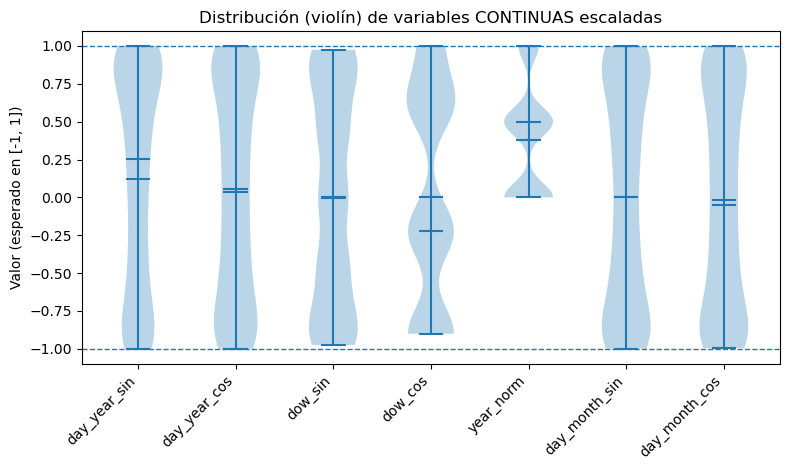

In [9]:
# =============================
# 4) PREPROCESADO: CONTINUAS YA ESCALADAS (-1 a 1)
# =============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_proc = df.copy()

# Detectar qué columnas existen realmente
binarias_presentes  = [c for c in BINARIAS  if c in df_proc.columns]
continuas_presentes = [c for c in CONTINUAS if c in df_proc.columns]

# Escalador SOLO para el target (Sales); las continuas ya están en [-1, 1]
from sklearn.preprocessing import StandardScaler
scaler_target = StandardScaler()
scaler_cont = None  # explícitamente sin escalado adicional de CONTINUAS

print('Binarias presentes (no se escalan):', binarias_presentes)
print('Continuas presentes (ya escaladas en [-1,1]):', continuas_presentes)

# --- Validación suave de rangos para CONTINUAS ---
if len(continuas_presentes) > 0:
    stats_cont = df_proc[continuas_presentes].agg(['min','max']).T
    fuera_rango = stats_cont[(stats_cont['min'] < -1.05) | (stats_cont['max'] > 1.05)]
    print("\nResumen rangos CONTINUAS (esperado ≈ [-1,1]):")
    display(stats_cont.sort_index())

    if not fuera_rango.empty:
        print("⚠️ Aviso: se detectaron variables fuera de [-1.05, 1.05]. Revísalas:")
        display(fuera_rango)

# --- Gráfico de violín para CONTINUAS ---
if len(continuas_presentes) > 0:
    vals = [df_proc[c].dropna().values for c in continuas_presentes]

    plt.figure(figsize=(max(8, 0.8*len(continuas_presentes)), 4.8))
    parts = plt.violinplot(vals, showmeans=True, showextrema=True, showmedians=True)

    # Etiquetas en eje X
    plt.xticks(
        ticks=np.arange(1, len(continuas_presentes)+1),
        labels=continuas_presentes,
        rotation=45,
        ha='right'
    )
    plt.axhline(-1, linestyle='--', linewidth=1)
    plt.axhline( 1, linestyle='--', linewidth=1)
    plt.title('Distribución (violín) de variables CONTINUAS escaladas')
    plt.ylabel('Valor (esperado en [-1, 1])')
    plt.tight_layout()
    plt.show()
else:
    print("No hay CONTINUAS presentes para graficar.")


In [10]:
# =============================
# 5) ENVENTANADO (many-to-one, 1-step)
# =============================
def enventanar_array(arr_X, arr_y, time_steps):
    """
    Construye X,y para many-to-one:
      X: [n_muestras, time_steps, n_features]
      y: [n_muestras, 1]  (Sales en t+1)
    """
    Xs, ys = [], []
    for i in range(len(arr_y) - time_steps):
        Xs.append(arr_X[i:i+time_steps])
        ys.append(arr_y[i+time_steps])  # 1 paso adelante
    Xs = np.array(Xs)
    ys = np.array(ys).reshape(-1, 1)
    return Xs, ys

In [11]:
# =============================
# 6) PARTICIÓN TEMPORAL
# =============================
# Opción A: FECHA_CORTE si está definida. Opción B: proporción TRAIN_TEST_RATIO
if FECHA_CORTE is not None:
    fecha_corte = pd.to_datetime(FECHA_CORTE)
    mask_train = df_proc[DATE_COL] < fecha_corte
else:
    n = len(df_proc)
    corte = int(n * TRAIN_TEST_RATIO)
    fecha_corte = df_proc.loc[corte, DATE_COL]
    mask_train = df_proc.index < corte

df_train = df_proc[mask_train].copy()
df_test  = df_proc[~mask_train].copy()

print('Fecha de corte:', fecha_corte.strftime('%Y-%m-%d'))
print('Train:', df_train.shape, 'Test:', df_test.shape)

# Dentro de train: reservar los últimos NVAL para validación
if len(df_train) <= NVAL + TIME_STEPS + 1:
    raise ValueError('Tramo de entrenamiento insuficiente para reservar NVAL y ventana TIME_STEPS.')

df_train_eff = df_train.iloc[:-NVAL].copy()
df_val       = df_train.iloc[-NVAL:].copy()

print('Train efectivo:', df_train_eff.shape, 'Validation:', df_val.shape)

Fecha de corte: 2014-12-06
Train: (704, 16) Test: (177, 16)
Train efectivo: (644, 16) Validation: (60, 16)


In [ ]:
# Ajustar escaladores SOLO con train efectivo (buena práctica en TS)
# Target
scaler_target.fit(df_train_eff[[TARGET_COL]])

# Continuas
if scaler_cont is not None and len(continuas_presentes) > 0:
    scaler_cont.fit(df_train_eff[continuas_presentes])

def transformar_df(df_in):
    df_out = df_in.copy()
    # target escalado
    df_out[TARGET_COL + '_scaled'] = scaler_target.transform(df_out[[TARGET_COL]])
    # continuas escaladas
    if scaler_cont is not None and len(continuas_presentes) > 0:
        df_out[[c + '_scaled' for c in continuas_presentes]] = scaler_cont.transform(df_out[continuas_presentes])
    return df_out

df_train_eff = transformar_df(df_train_eff)
df_val       = transformar_df(df_val)
df_test      = transformar_df(df_test)

df_train_eff.head(2)

,Date,Sales,Open,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,year_norm,day_year_sin,day_year_cos,dow_sin,dow_cos,day_month_sin,day_month_cos,Sales_scaled
0,2013-01-01,0.0,0,0,0,0,0,1,1,0.0,0.017202,0.999852,0.974928,-0.222521,0.201299,0.979530,-1.826442
1,2013-01-02,6089.0,1,0,0,1,1,1,1,0.0,0.034398,0.999408,0.433884,-0.900969,0.394356,0.918958,0.503206


In [14]:
def construir_X(df_in, columnas_uso):
    feats = []

    # 1) endógena escalada (siempre existe)
    feats.append(df_in[TARGET_COL + '_scaled'].values.reshape(-1, 1))

    # 2) binarios sin escalar
    for c in [col for col in columnas_uso if col in BINARIAS]:
        feats.append(df_in[c].values.reshape(-1, 1))

    # 3) continuas: usa *_scaled si existe; si no, usa la original
    for c in [col for col in columnas_uso if col in continuas_presentes]:
        col_scaled = c + '_scaled'
        if col_scaled in df_in.columns:
            feats.append(df_in[col_scaled].values.reshape(-1, 1))
        elif c in df_in.columns:
            feats.append(df_in[c].values.reshape(-1, 1))
        else:
            raise KeyError(f"No encuentro la continua '{c}' ni '{col_scaled}' en el DF.")

    X_mat = np.hstack(feats)
    y_vec = df_in[TARGET_COL + '_scaled'].values
    return X_mat, y_vec


In [20]:
import tensorflow as tf

# Versión
print("Versión TensorFlow:", tf.__version__)

# Detección de GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("✅ GPU detectada:", gpus)
else:
    print("⚠️ No se detecta GPU, correrá en CPU")

# Prueba rápida con una LSTM dummy
import numpy as np
X_dummy = np.random.rand(10, 5, 3)   # 10 muestras, 5 pasos de tiempo, 3 features
y_dummy = np.random.rand(10, 1)

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(16, input_shape=(5,3)),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer="adam", loss="mse")
model.fit(X_dummy, y_dummy, epochs=1, verbose=1)

print("✅ LSTM de prueba entrenada correctamente")


Versión TensorFlow: 2.18.1
⚠️ No se detecta GPU, correrá en CPU


c:\Users\falva\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.8418
✅ LSTM de prueba entrenada correctamente


In [25]:
# =============================
# 7) MODELO LSTM (many-to-one, 1 salida)
# =============================
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, metrics

tf.random.set_seed(RANDOM_SEED)

n_features = df_train_eff.shape[-1]


model = models.Sequential([
    layers.Input(shape=(TIME_STEPS, n_features)),
    layers.LSTM(LSTM_UNITS, activation='tanh', recurrent_activation='sigmoid'),
    layers.Dropout(DROPOUT),
    layers.Dense(1)  # 1 paso
])

model.compile(
    loss='mse',
    optimizer=optimizers.RMSprop(),
    metrics=METRICAS
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        20,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,057 (82.25 KB)

 Trainable params: 21,057 (82.25 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# =============================
# 8) ENTRENAMIENTO con EarlyStopping & Checkpoint
# =============================
ckpt_path = 'baseline2_lstm_best.keras'

es = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

ckpt = callbacks.ModelCheckpoint(
    ckpt_path, monitor='val_loss', save_best_only=True, verbose=1
)

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_va, y_va),
    epochs=EPOCHS_MAX,
    batch_size=BATCH_SIZE,
    callbacks=[es, ckpt],
    verbose=1
)

# Detectar mejor época para marcar en la gráfica
val_losses = history.history['val_loss']
best_epoch = int(np.argmin(val_losses))
best_val = float(np.min(val_losses))
print(f'Mejor época (0-index): {best_epoch}  |  val_loss: {best_val:.6f}')

NameError: name 'X_tr' is not defined

In [ ]:
# =============================
# 9) EVALUACIÓN: MAE, sMAPE, R2
# =============================
from sklearn.metrics import mean_absolute_error, r2_score

def smape(y_true, y_pred, eps=1e-8):
    denom = (np.abs(y_true) + np.abs(y_pred)) + eps
    return 100.0 * np.mean(2.0 * np.abs(y_pred - y_true) / denom)

def desescalar_target(y_scaled):
    return scaler_target.inverse_transform(y_scaled.reshape(-1,1)).ravel()

# Predicciones en val y test (esquema directo 1 paso)
y_va_hat_scaled = model.predict(X_va).ravel()
y_te_hat_scaled = model.predict(X_te).ravel()

# Desescalar
y_va_true = desescalar_target(y_va)
y_va_hat  = desescalar_target(y_va_hat_scaled)
y_te_true = desescalar_target(y_te)
y_te_hat  = desescalar_target(y_te_hat_scaled)

# Métricas
mae_va = mean_absolute_error(y_va_true, y_va_hat)
mae_te = mean_absolute_error(y_te_true, y_te_hat)
smape_va = smape(y_va_true, y_va_hat)
smape_te = smape(y_te_true, y_te_hat)
r2_va = r2_score(y_va_true, y_va_hat)
r2_te = r2_score(y_te_true, y_te_hat)

print(f'Validation -> MAE: {mae_va:.3f} | sMAPE: {smape_va:.2f}% | R²: {r2_va:.3f}')
print(f'Test       -> MAE: {mae_te:.3f} | sMAPE: {smape_te:.2f}% | R²: {r2_te:.3f}')

In [ ]:
# =============================
# 10) GRÁFICAS
# =============================
import matplotlib.pyplot as plt

# a) Pérdidas train/val con punto rojo en mejor época
plt.figure(figsize=(7,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.scatter([best_epoch], [history.history['val_loss'][best_epoch]], s=60, marker='o', color='red', label='mejor val_loss')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('MSE')
plt.legend()
plt.tight_layout()
plt.show()

# b) Reales vs. predichas (Validation)
plt.figure(figsize=(9,4))
plt.plot(y_va_true, label='Real (val)')
plt.plot(y_va_hat, label='Predicho (val)', alpha=0.8)
plt.title('Validación: Real vs. Predicho (desescalado)')
plt.xlabel('t')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()

# c) Reales vs. predichas (Test)
plt.figure(figsize=(9,4))
plt.plot(y_te_true, label='Real (test)')
plt.plot(y_te_hat, label='Predicho (test)', alpha=0.8)
plt.title('Test: Real vs. Predicho (desescalado)')
plt.xlabel('t')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# =============================
# 11) FORECAST 1 PASO (DEMO explícita sobre inicio de test)
# =============================
# Tomamos la última ventana de validation y predecimos el siguiente punto (inicio del test)
if len(X_va) > 0:
    last_win = X_va[-1:]
    next_scaled = model.predict(last_win).ravel()[0]
    next_real = desescalar_target(np.array([next_scaled]))[0]
    print(f'Pronóstico 1 paso (inicio test): {next_real:.2f} (unidades de Sales)')

## 12) Notas y siguientes pasos
- Este baseline es **many-to-one** con **pronóstico de 1 día**.
- En **multivariante**, binarios **no se escalan**; continuas/cíclicas sí.
- Si `weekofyear` se usa, idealmente codificarla cíclicamente (`sin/cos`).
- Si el horizonte futuro requerido crece y conocemos exógenas futuras, considerar **multi-output directo** para evitar acumulación de error.
- Ajustar `FECHA_CORTE` para replicar cortes específicos por negocio o eventos.

> **Recordatorio:** LSTM usa por defecto `activation='tanh'` y `recurrent_activation='sigmoid'`. No forzar `relu` en celdas LSTM.
